In [190]:
from pathlib import Path
from IPython.display import display

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import ast

In [191]:
# data directory
data_dir = Path("../data")
collection_dir = data_dir / "collection"
twitter_dir = data_dir / "twitter"

jsonl_files = list(collection_dir.glob("*.jsonl"))

In [375]:
# soad news sources
news_sources = pd.read_csv(data_dir / "news_sources.csv")

# remove popsci RSS feed
news_sources = news_sources[news_sources.short_name!="popsci"]

venue_names = news_sources["short_name"].tolist()
feed_urls = news_sources["feed_url"].tolist()

## Merge RSS feeds

In [628]:
dfs = {}
for f in jsonl_files:
    if f.name.split(".")[0] in venue_names:
        df = pd.read_json(f, orient="records", lines=True)
        df = df.drop_duplicates(subset="link", keep="last").reset_index()
        dfs[f.name.split(".")[0]] = df
    
columns = []
sources = []
for k, df in dfs.items():
    sources.append(k)
    columns.append(df.columns)
all_vals = set([j for i in columns for j in i])

In [629]:
cols = ["link", "title", "id", "published", "summary", "tags", "author"]

select_dfs = []
for k, df in dfs.items():
    _ = df[[]].copy()
    _["source"] = k
    for c in cols:
        if c in df:
            _[c] = df[c]
        else:
            _[c] = None
    select_dfs.append(_)

## Filter items that do not match "science" categories

In [630]:
articles = pd.concat(select_dfs)
articles["published"] = pd.to_datetime(articles["published"])
articles["published_day"] = articles["published"].dt.date

from_date = "2021-03-01"
until_date = "2021-04-01"

articles = articles[(articles.published>=from_date)]
# articles = articles[articles.published<until_date]

In [631]:
source_counts = articles.groupby("source").size()

bad_indices = []

for s in ["guardian", "nyt"]:
    df = articles[(articles.source==s)]
    _ = df[~df.link.str.contains("/science/")]
    
    p = 100 * len(_) / source_counts.loc[s]
    print(f"{s} articles outside of `/science/`: {len(_)} ({p:.2f})")
    bad_indices = bad_indices + _.id.tolist()

articles = articles[~articles.id.isin(bad_indices)].reset_index(drop=True)

guardian articles outside of `/science/`: 290 (70.39)
nyt articles outside of `/science/`: 217 (77.22)


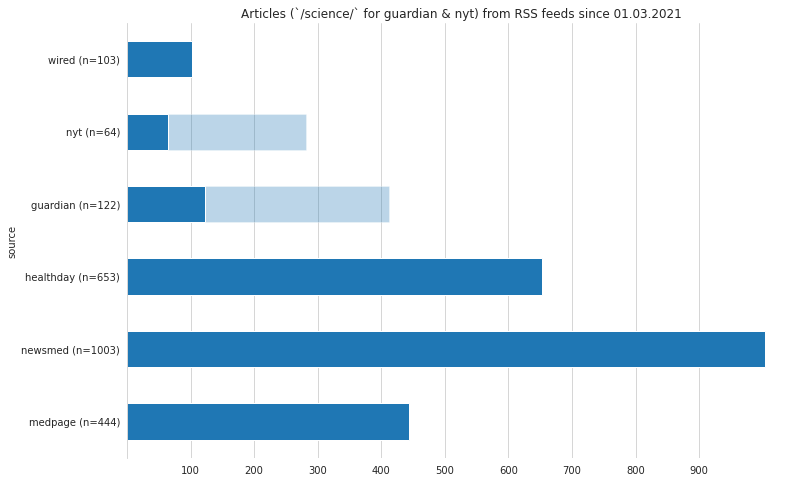

In [632]:
plt.figure(figsize=(12,8))
with sns.axes_style("whitegrid"):
    ax = source_counts.loc[venue_names[::-1]].plot(kind="barh", alpha=.3)
    pdf = articles.groupby("source").size()
    pdf.loc[venue_names[::-1]].plot(kind="barh", ax=ax)
    sns.despine(bottom=True)
    plt.grid(False, axis="y")
    xticks = range(100, 1000, 100)
    yticks, labels = plt.yticks()
    labels = [f"{_.get_text()} (n={pdf[_.get_text()]})" for _ in labels]
    plt.yticks(ticks=yticks, labels=labels)
    plt.xticks(xticks, xticks)
    plt.title("Articles (`/science/` for guardian & nyt) from RSS feeds since 01.03.2021")

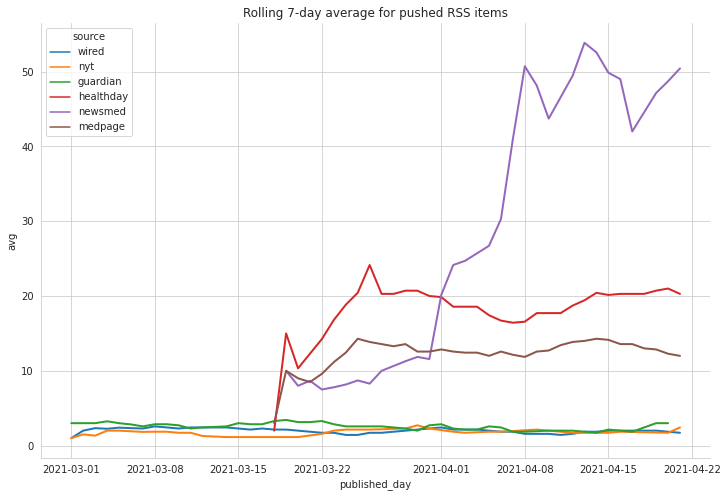

In [633]:
pdf = articles.groupby(["source", "published_day"], as_index=False)["link"].size()
pdf["avg"] = pdf.groupby("source").rolling(7, 1)["size"].mean().reset_index(drop=True)

plt.figure(figsize=(12,8))
with sns.axes_style("whitegrid"):
    sns.lineplot(data=pdf, x="published_day", y="avg", hue="source", hue_order=venue_names, linewidth=2)
#     plt.xticks(rotation=45, ha="right");
    sns.despine()
    plt.title("Rolling 7-day average for pushed RSS items")

In [634]:
dfs = []

files = ["IFLScience.csv", "PopSci.csv"]
filters = ["https://www.iflscience.com/", "story/science/"]
short_names = ["ifls", "popsci"]

counts = []

for f, filt, sn in zip(files, filters, short_names):
    df = pd.read_csv(twitter_dir / f, index_col=0, converters={"urls":ast.literal_eval})
    counts.append(len(df))
    cleaned_df = df.copy()
    cleaned_df["url"] = cleaned_df.urls.map(lambda x: x[0] if x else None)
    cleaned_df = cleaned_df[cleaned_df.url.notna()]
    cleaned_df = cleaned_df[cleaned_df.url.str.contains(filt)]
    cleaned_df = cleaned_df.drop_duplicates(subset=["url"], keep="last")
    cleaned_df["source"] = sn

    dfs.append(cleaned_df)
df = pd.concat(dfs)

df["published_day"] = pd.to_datetime(df.date).dt.date

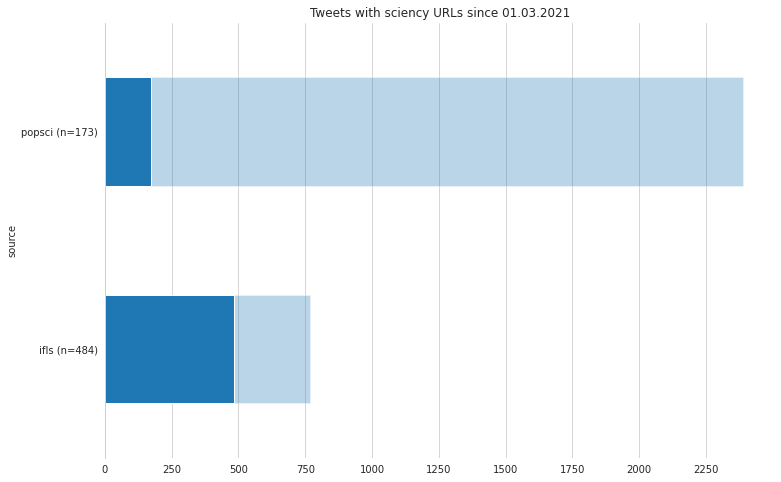

In [635]:
plt.figure(figsize=(12,8))
with sns.axes_style("whitegrid"):
    source_counts = pd.Series(data=counts, index=short_names)
    ax = source_counts.plot(kind="barh", alpha=.3)
    pdf = df.groupby("source").size()
    pdf.plot(kind="barh", ax=ax)
    
    yticks, labels = plt.yticks()
    labels = [f"{_.get_text()} (n={pdf[_.get_text()]})" for _ in labels]
    plt.yticks(ticks=yticks, labels=labels)
    sns.despine(bottom=True)
    plt.grid(False, axis="y")
    xticks = range(0, 2500, 250)
    plt.xticks(xticks, xticks)
    plt.title("Tweets with sciency URLs since 01.03.2021")

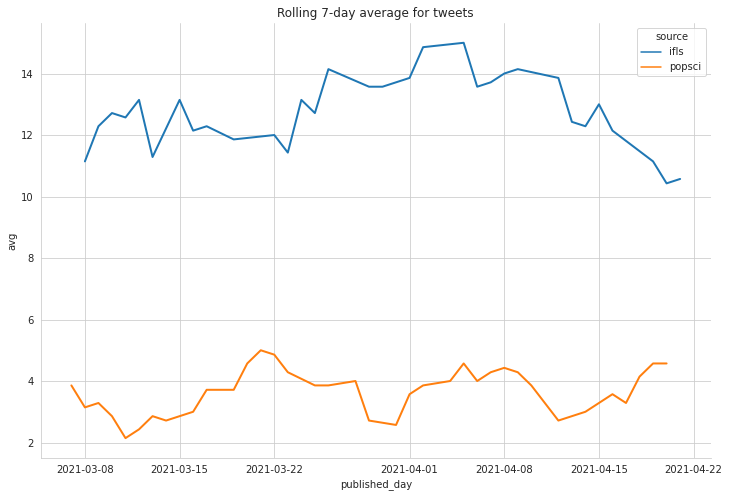

In [627]:
pdf = df.groupby(["source", "published_day"], as_index=False)["url"].size()
pdf["avg"] = pdf.groupby("source").rolling(7)["size"].mean().reset_index(drop=True)

plt.figure(figsize=(12,8))
with sns.axes_style("whitegrid"):
    sns.lineplot(data=pdf, x="published_day", y="avg", hue="source", linewidth=2)
#     plt.xticks(rotation=45, ha="right");
    sns.despine()
    plt.title("Rolling 7-day average for tweets")

In [ ]:
plt.figure(figsize=(12,8))
with sns.axes_style("whitegrid"):
    ax = source_counts.loc[venue_names[::-1]].plot(kind="barh", alpha=.3)
    articles.groupby("source").size().loc[venue_names[::-1]].plot(kind="barh", ax=ax)
    sns.despine(bottom=True)
    xticks = range(100, 1000, 100)
    plt.xticks(xticks, xticks)
    plt.title("Articles (`/science/` for guardian & nyt) from RSS feeds since 01.03.2021")